In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import itertools as it

path_root = os.path.join(os.environ['E3SM_ROOT'], 'inputdata', 'lnd', 'clm2', 'surfdata_map')
file_orig = os.path.join(path_root, #'landuse.timeseries_conus_erw_off_hist_simyr1850_c240712.nc')
                         'landuse.timeseries_0.5x0.5_combined_simyr1850-2100_c240508_newlon.nc')
file_temp = os.path.join(path_root, 'landuse.conus_erw.temp.nc')

# copy from the non-ERW file
os.system(f"cp {file_orig} {file_temp}")

hr = xr.open_dataset(file_temp)

In [2]:
# Grain sizes: 10-1000 um
# Application rates: 20-100 t/ha => 2-10 kg/m2
# Day of year: Jan 1 # 244 (Sep-1 in nonleap years)
mpft = 17
planning_start = 2025
planning_end = 2050
day_of_application = 1 # 244
namendspec = 10

# minerals_name = ['Wollastonite_CaSiO3', 'Forsterite_Mg2SiO4', 'Albite_NaAlSi3O8', 
#                 'Anorthite_CaAl2Si2O8', 'Epidote_Ca2FeAl2(SiO4)3(OH)', 'Calcite_CaCO3',
#                 'Labradorite_Ca0.6Na0.4Al1.6Si2.4O8', 'Augite_Ca0.9Mg0.9Na0.1Al0.4Fe0.2Si1.9O6',
#                 'Kfeldspar_KAlSi3O8', 'Enstatite_MgSiO3']
# normal alkali basalt (fast)
pct_basalt = np.array([0, 12, 0, 0, 0, 0, 43, 21, 6, 0])
# normal tholeiitic basalt (slow)
# pct_basalt = np.array([0, 0, 0, 0, 0, 0, 45, 34, 5, 3])

# tuples = list(it.product(np.linspace(10, 1000, 10), np.linspace(2, 10, 10)))
grain_size = [2, 10, 20, 50, 100]
app_rate = [2, 4, 6, 8, 10]
app_freq = [1,3,9,999]
start_year = np.arange(planning_start, planning_end + 1)

In [3]:
# Create a giant array that use 1/0 to indicate rock powder applied/not applied
app_occ_tuples = np.full([len(start_year) * len(app_freq), 2], -1)
app_occurrence = np.full([len(start_year) * len(app_freq), len(hr['time'])], False)
count = 0
for sy, af in it.product(start_year, app_freq):
    selection = np.arange(sy, planning_end + 1, af) - hr['time'].to_index()[0]
    app_occurrence[count, selection] = True
    app_occ_tuples[count, :] = np.array([sy, af])
    count = count + 1

# Get the indices of the first occurrence of each unique row
app_occurrence, indices = np.unique(app_occurrence, axis=0, return_index=True)
app_occ_tuples = app_occ_tuples[indices, :]

In [4]:
# Save the grain size, app rate, start year, and app freq
tuples = [(1,0,-1,-1)]
for gra, app, tup in it.product(grain_size, app_rate, app_occ_tuples):
    tuples.append([gra, app, tup[0], tup[1]])
np.savetxt(os.path.join(os.environ['E3SM_ROOT'], 'inputdata', 'lnd', 'clm2', 'surfdata_map', 
                        'erw_ensemble_record.txt'), np.array(tuples))

In [5]:
# Please make sure each time step has valid values, because the streamfile reader
# is updating every year!
count = 0
for gra, app, tup_count in it.product(grain_size, app_rate, range(len(app_occ_tuples))):
    doy = np.full([len(hr['time']), mpft, len(hr['lsmlat']), len(hr['lsmlon'])],
                  day_of_application, dtype = np.float32)
    hr['SOIL_AMENDMENTS_DOY'] = xr.DataArray(doy, 
        dims = ['time','mpft','lsmlat','lsmlon'],
        attrs = {'long_name': 'soil amendment application day of year',
                 'units': 'day of year'})

    rate = np.zeros([len(hr['time']), mpft, len(hr['lsmlat']), len(hr['lsmlon'])],
                    dtype = np.float32)
    rate[app_occurrence[tup_count, :], :, :, :] = app
    hr['SOIL_AMENDMENTS_RATE'] = xr.DataArray(rate, 
        dims = ['time','mpft','lsmlat','lsmlon'],
        attrs = {'long_name': 'soil amendment application rate',
                 'units': 'kg/m2/yr'})

    size = np.full([len(hr['time']), len(hr['lsmlat']), len(hr['lsmlon'])], 
                   gra, dtype = np.float32)
    hr['SOIL_AMENDMENTS_GRAINSIZE'] = xr.DataArray(size, 
        dims = ['time','lsmlat','lsmlon'],
        attrs = {'long_name': 'grain size of applied soil amendment',
                 'units': 'micro meters'})

    pct = np.full([len(hr['time']), namendspec, len(hr['lsmlat']), len(hr['lsmlon'])], 
                  np.nan, dtype = np.float32)
    pct[:, :, :, :] = pct_basalt.reshape(1, -1, 1, 1)
    hr['SOIL_AMENDMENTS_PCT'] = xr.DataArray(pct, 
        dims = ['time','namendspec','lsmlat','lsmlon'],
        attrs = {'long_name': 'species fraction of applied soil amendment',
                 'units': 'percent'})

    hr['namendspec'] = xr.DataArray(
          np.arange(1, namendspec+1), dims = ['namendspec'],
          attrs = {'long_name': 'indices of species in soil amendment mixture (e.g. rock powder)',
                   'units': 'index'}
    )

    hr['mpft'] = xr.DataArray(
          np.arange(1, mpft+1), dims = ['mpft'],
          attrs = {'long_name': 'indices of natural PFTs and cfts, if any',
                   'units': 'index'}
    )

    file_dest = os.path.join(path_root, 'erw_ensemble', f'landuse.timeseries_conus_erw_on_combined_simyr1850-2100_c240508_ensemble_{count}.nc')

    chunking = {'time': 10}  # Adjust based on your dataset

    encoding = {}
    for var in hr.data_vars:
        if var in ['SOIL_AMENDMENTS_DOY', 'SOIL_AMENDMENTS_RATE', 'SOIL_AMENDMENTS_GRAINSIZE',
                   'SOIL_AMENDMENTS_PCT']:
            encoding[var] = {'_FillValue': 1e20, 'chunksizes': chunking}
        else:
            if 'time' in hr[var].dims:
                encoding[var] = {'_FillValue': None, 'chunksizes': chunking}
            else:
                encoding[var] = {'_FillValue': None}

    hr.to_netcdf(file_dest, encoding=encoding, format = 'NETCDF4_CLASSIC', compute=True)

    count = count + 1

: 

In [ ]:
hr.close()

os.system(f'rm {file_temp}')

0

In [ ]:
np.where(np.isnan(hr['SOIL_AMENDMENTS_RATE']))

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

: 

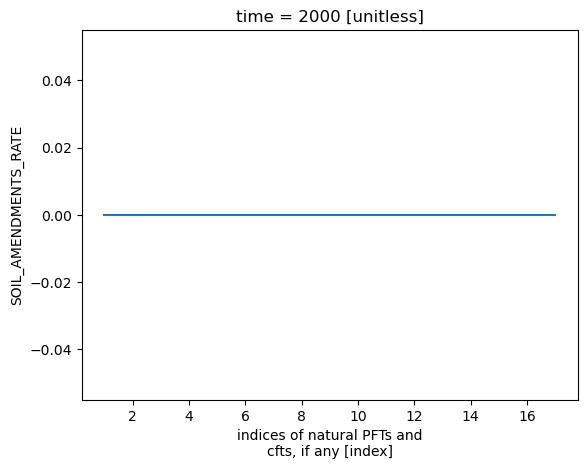

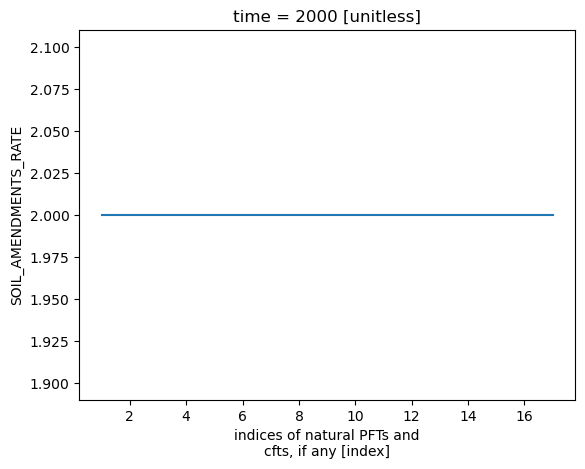

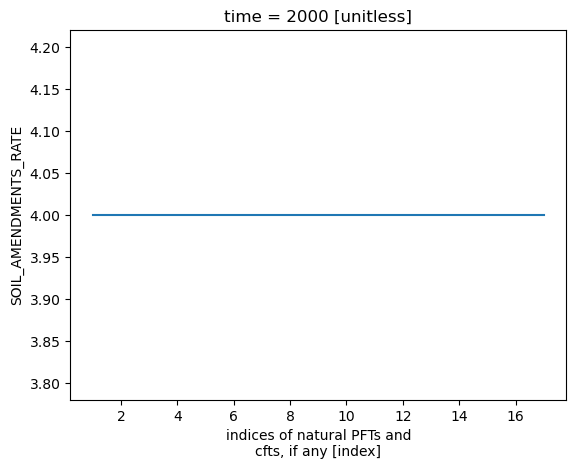

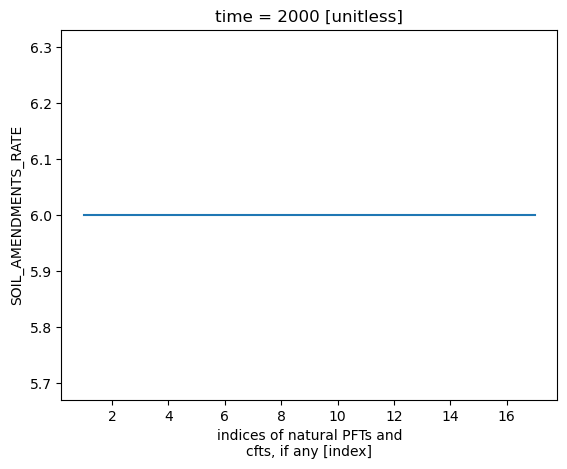

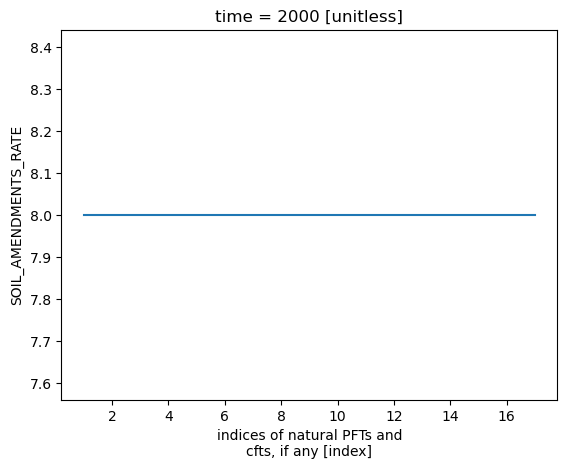

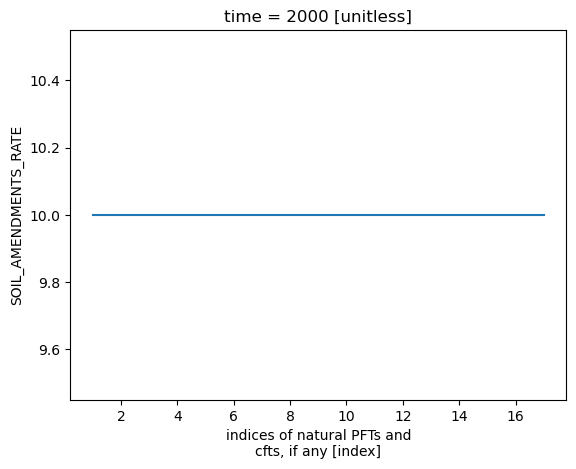

In [ ]:
# Check the outcome
import matplotlib.pyplot as plt

count = 0
for gra, app, tup_count in it.product(grain_size[::2], app_rate[::2], 
                                      range(0, len(app_occ_tuples), 5)):

    file_dest = os.path.join(path_root, 'erw_ensemble', f'landuse.timeseries_conus_erw_on_combined_simyr1850-2100_c240508_ensemble_{count}.nc')
    hr = xr.open_dataset(file_dest)

    plt.figure()
    hr['SOIL_AMENDMENTS_RATE'][:, 1, 0, 0].plot()

    hr.close()
    count = count + 1